# Workflow

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import sys

sys.path.append('../hydra_tod/')

from astropy.coordinates import EarthLocation, AltAz, SkyCoord
from astropy.time import Time, TimeDelta
import astropy.units as u
from utils import Leg_poly_proj
from flicker_model import sim_noise, flicker_cov
from simulation import * 
import pickle


## Simulation

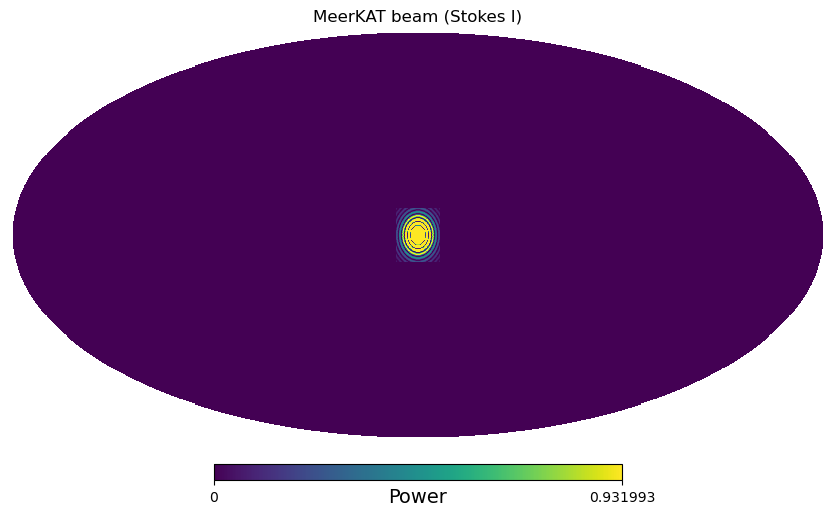

In [2]:
def example_katbeam_healpix():
    """
    Example: generate a MeerKAT beam model on a HEALPix grid using katbeam
    """

    import katbeam

    # --- beam on a Cartesian grid ---
    beam = katbeam.JimBeam("MKAT-AA-L-JIM-2020")
    beam_grid_size = 20.0       # degrees
    Nx = Ny = 300
    freq = 900.0                # MHz
    delta = np.linspace(-beam_grid_size/2, beam_grid_size/2, Nx)
    x2d, y2d = np.meshgrid(delta, delta)
    beam_pix_I = beam.I(x2d, y2d, freq)       # Stokes I, in power

    # --- choose nside (resolution) ---
    nside = 512        # ~7 arcmin pixels; adjust as needed
    npix  = hp.nside2npix(nside)

    # coordinates of every HEALPix pixel
    theta, phi = hp.pix2ang(nside, np.arange(npix))

    # convert beam’s (x,y) [deg] to polar offsets
    r   = np.degrees(theta)            # θ from boresight in deg
    az  = np.degrees(phi)              # φ around beam axis in deg

    # bilinear interpolation on the beam grid
    from scipy.interpolate import RegularGridInterpolator

    interp = RegularGridInterpolator(
        (delta, delta), beam_pix_I, bounds_error=False, fill_value=0.0
    )
    xy = np.column_stack([ r*np.cos(np.radians(az)),
                        r*np.sin(np.radians(az)) ])
    beam_hp = interp(xy)

    # hp.write_map("MeerKAT_beam_I.fits", beam_hp)
    hp.mollview(beam_hp, title="MeerKAT beam (Stokes I)", rot=(0,90), unit="Power", norm="hist")
    return beam_hp

beam_hp = example_katbeam_healpix()

In [3]:
t_list, azi_deg_list = sim_MeerKAT_scan_v2(az_s=-60.3, 
                                       az_e=-42.3, 
                                       dt=2.0)


In [4]:
from astropy.time import Time, TimeDelta
from astropy.coordinates import EarthLocation
import numpy as np


def generate_LSTs_rad(t_list, start_time_utc="2019-04-23 20:41:56.397"):

    # start_time_utc="2019-04-23 20:41:56.397"
    # --- site coordinates (example: MeerKAT) ---
    site = EarthLocation(lat=-30.713*u.deg, lon=21.443*u.deg, height=1050*u.m)

    # --- define start time and offsets (sec) ---
    start_time = Time(start_time_utc)                     # e.g. "2025-09-16T00:00:00"
    UTC_list = start_time + TimeDelta(t_list, format="sec")

    # --- compute Local Sidereal Time ---
    LST_list = UTC_list.sidereal_time("apparent", longitude=site.lon)

    # convert to radians (Angle object → value)
    LST_list_rad = LST_list.to(u.rad).value

    return LST_list_rad


LSTs_rad = generate_LSTs_rad(t_list, start_time_utc="2019-04-23 20:41:56.397")

In [9]:
hp.map2alm(beam_hp, lmax=200)


array([ 2.48505956e-04+0.00000000e+00j,  4.30344954e-04+0.00000000e+00j,
        5.55370209e-04+0.00000000e+00j, ...,
       -2.75798199e-24+1.31764767e-24j, -2.37295453e-24-1.94582295e-24j,
       -1.01338100e-25+1.24890081e-24j])

In [ ]:
# Test the corrected function
stacked_beam_map = integrated_beam_map_single_TOD(
    beam_hp,
    ant_lat=np.radians(-30.713),
    ant_ele=np.radians(41.5),
    ant_azi_list=np.radians(azi_deg_list),
    LST_list=LSTs_rad,
    lmax=200,
    facing_north=True,
    nside=64
)

print(f"stacked_beam_map shape: {stacked_beam_map.shape}")
print(f"stacked_beam_map min/max: {np.min(stacked_beam_map):.3e} / {np.max(stacked_beam_map):.3e}")
print("Success!")

Original alm first few values: [0.00024851+0.j 0.00043034+0.j 0.00055537+0.j 0.00065676+0.j
 0.00074415+0.j]
rotate_alm returned: None
alm_copy first few values after rotation: [0.00024851+0.j 0.00042819+0.j 0.00054703+0.j 0.00063711+0.j
 0.00070723+0.j]
alm_copy changed: True
rotate_alm with lmax returned: None
alm_copy2 changed: True
rotate_alm with lmax returned: None
alm_copy2 changed: True


In [10]:
alpha

NameError: name 'alpha' is not defined

In [4]:
# Create the simulation instance
tod_sim = TODSimulation()

# Print simulation summary
print("\nSimulation Summary:")
for key, value in tod_sim.get_simulation_summary().items():
    print(f"{key}: {value}")

# Save the class object of TODSimulation
# This can be done using pickle or any other serialization method


Number of pixels: 375
Gain parameters: [6.31194264 0.42038942 0.264222   0.05578821]

Simulation Summary:
nside: 64
n_pixels: 375
n_time_samples: 2860
frequency_MHz: 750
beam_FWHM_deg: 1.1
elevation_deg: 41.5
azimuth_range_deg: (-60.3, -42.3)
gain_params: [6.31194264 0.42038942 0.264222   0.05578821]
noise_knee_freq_Hz: 1.3348390111267891e-05
noise_spectral_index: 2.0
T_ndiode_K: 15.0
receiver_params_K: [12.6  0.5  0.5  0.5]

Simulation Summary:
nside: 64
n_pixels: 375
n_time_samples: 2860
frequency_MHz: 750
beam_FWHM_deg: 1.1
elevation_deg: 41.5
azimuth_range_deg: (-60.3, -42.3)
gain_params: [6.31194264 0.42038942 0.264222   0.05578821]
noise_knee_freq_Hz: 1.3348390111267891e-05
noise_spectral_index: 2.0
T_ndiode_K: 15.0
receiver_params_K: [12.6  0.5  0.5  0.5]


In [ ]:
with open('tod_simulation_single.pkl', 'wb') as f:
    pickle.dump(tod_sim, f)

In [2]:

# Create the multi-TOD simulation instance
multi_tod_sim = MultiTODSimulation()

# Print simulation summary
print("\nMulti-TOD Simulation Summary:")
summary = multi_tod_sim.get_simulation_summary()
for key, value in summary.items():
    if isinstance(value, dict):
        print(f"{key}:")
        for subkey, subvalue in value.items():
            print(f"  {subkey}: {subvalue}")
    else:
        print(f"{key}: {value}")

Number of pixels: 473

Multi-TOD Simulation Summary:
nside: 64
n_pixels: 473
n_time_samples: 2860
frequency_MHz: 750
beam_FWHM_deg: 1.1
setting_scan:
  elevation_deg: 41.5
  azimuth_range_deg: (-60.3, -42.3)
  gain_params: [6.31194264 0.42038942 0.264222   0.05578821]
rising_scan:
  elevation_deg: 40.5
  azimuth_range_deg: (43.7, 61.7)
  gain_params: [6.84507868 0.14156859 0.7441104  0.77863955]
noise_knee_freq_Hz: 1.3348390111267891e-05
noise_spectral_index: 2.0
T_ndiode_K: 15.0
receiver_params_K: [12.6  0.5  0.5  0.5]
calibration_pixels:
  single_cal_index: [149]
  five_cal_indices: [np.int64(394), np.int64(344), np.int64(281), np.int64(254), np.int64(176)]


In [3]:
# Save the simulation data to a pickle file
with open('multi_tod_simulation_data.pkl', 'wb') as f:
    pickle.dump(multi_tod_sim, f)